### Імпорт бібліотек

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from utils import *

%matplotlib inline

### Завантажити набір даних

In [2]:
sample_submission = pd.read_csv('dataset/house-prices/sample_submission.csv') # приклад результату для перевірки
ds_train = pd.read_csv('dataset/house-prices/train.csv')                      # набір даних для тренування моделі
ds_test = pd.read_csv('dataset/house-prices/test.csv')                        # набір даних для тестування моделі
print(f"Розмірність набору даних для тренування моделі: {ds_train.shape}")
print(f"Розмірність набору даних для тестування моделі: {ds_test.shape}")
ds_train.head()

Розмірність набору даних для тренування моделі: (1460, 81)
Розмірність набору даних для тестування моделі: (1459, 80)


Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities    ...     PoolArea PoolQC Fence MiscFeature MiscVal  \
0         Lvl    AllPub    ...            0    NaN   NaN         NaN       0   
1         Lvl    AllPub    ...            0    NaN   NaN         NaN       0   
2         Lvl    AllPub    ...            0    NaN   NaN         NaN       0   
3         Lvl    AllPub    ...            0    NaN   NaN         NaN       0   
4         Lvl    AllPub    ...            0    NaN   NaN         NaN       0   

  MoSold YrSold  SaleType  SaleCondition  SalePrice  
0      2   2008        WD         Normal     208500  
1      5   2007        WD         Normal     181500  
2      9   2008        WD         Normal     223500  
3      2   2006        WD        Abnorml     140000  
4     12   2008        WD         Normal     250000  

[5 rows x 81 columns]

Як видно, набір даних для тренування містить 1460 спостережень, кожне з яких має 81 ознаку. При цьому ці 81 одна ознака складаються з: 
* "Id" - ідентифікатор кожного спостереження;
* 79 ознак, які характеризують кожне спостереження. Саме ці характеризуючі ознаки ми і будемо аналізувати та використовувати для тренування моделі;
* "SalePrice" - цільова ознака, а саме - вартість будинку. В тестовому наборі даних ця 81-а ознака відсутня. Саме цю ознаку нам і треба буде знайти нашою моделлю для тестового набору даних. 

### Перевірка, очищення, покращення та створення нових ознак

Як ми вже зазначили вище, ми маємо ознаку, яка не впливає на прогностичні здібності моделі - 'Id'. 
Видалемо цю ознаку.

In [3]:
# Видалемо колонку 'Id', оскільки вона не впливає на тренування та прогноз вартості
test_ids = ds_test.Id
dsc_train = drop_features(ds_train, ["Id"])
dsc_test = drop_features(ds_test, ["Id"])
print(f"Розмірність набору даних для тренування після видалення 'Id' та 'SalePrice': {dsc_train.shape}")
print(f"Розмірність набору даних для тестування після видалення 'Id': {dsc_test.shape}")

Розмірність набору даних для тренування після видалення 'Id' та 'SalePrice': (1460, 80)
Розмірність набору даних для тестування після видалення 'Id': (1459, 79)


### Проведемо первинний огляд "SalePrice"

In [4]:
dsc_train["SalePrice"].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

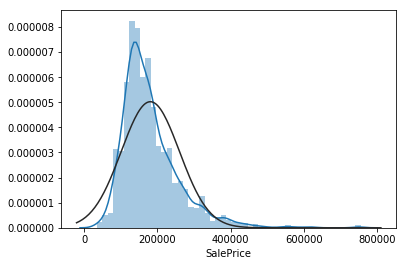

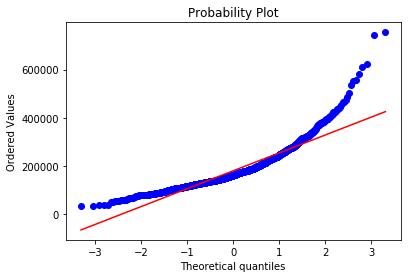

In [5]:
draw_hist_normal_prob_plot(dsc_train["SalePrice"], None)

Очевидно, що вартість має відхилення від нормального розподілу та позитивну асиметрію. Разом з тим відсутні нульові значення. Cхоже що "SalePrice" цілком придатна для тренування деяких моделей. Для лінійної моделі потрібно буде виконати нормалізацію.

### Log-трансформація цільової змінної

In [6]:
# dsc_train["SalePrice"] = np.log(dsc_train["SalePrice"])
# draw_hist_normal_prob_plot(dsc_train["SalePrice"], None)

Ок, тепер значення виглядають більш нормально розподіленими.

### Пропущені ознаки

Поглянемо, чи є в нас пропущені дані в тренувальному наборі даних.

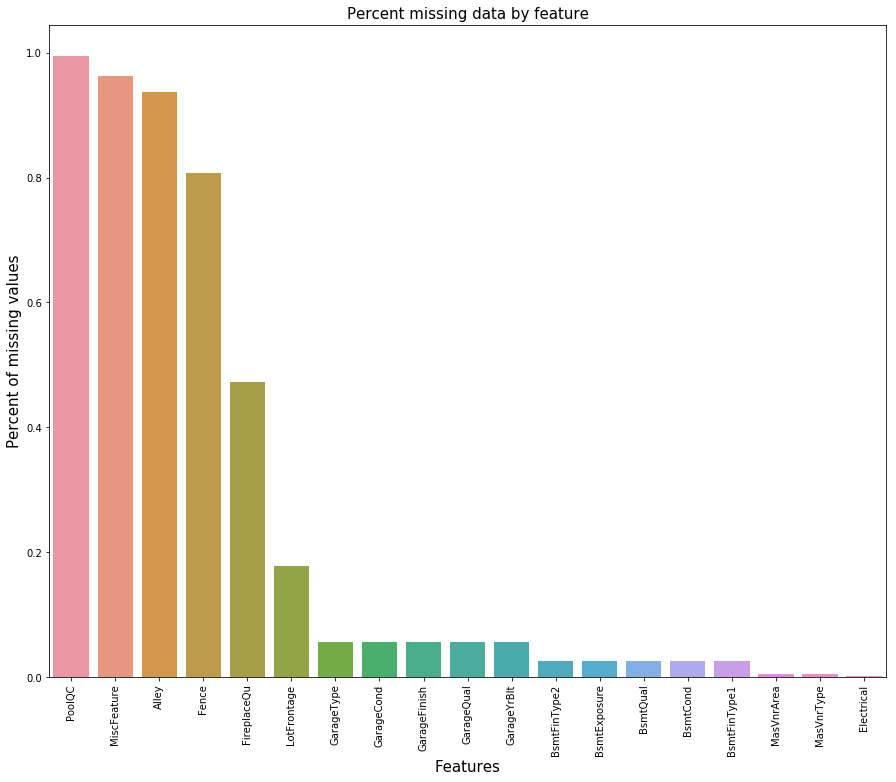

Total   Percent
PoolQC         1453  0.995205
MiscFeature    1406  0.963014
Alley          1369  0.937671
Fence          1179  0.807534
FireplaceQu     690  0.472603
LotFrontage     259  0.177397
GarageType       81  0.055479
GarageCond       81  0.055479
GarageFinish     81  0.055479
GarageQual       81  0.055479
GarageYrBlt      81  0.055479
BsmtFinType2     38  0.026027
BsmtExposure     38  0.026027
BsmtQual         37  0.025342
BsmtCond         37  0.025342
BsmtFinType1     37  0.025342
MasVnrArea        8  0.005479
MasVnrType        8  0.005479
Electrical        1  0.000685

In [7]:
missing_data_summary = summary_of_missing_data(dsc_train, True)
missing_data_summary

Зробимо те саме для тестового набору даних.

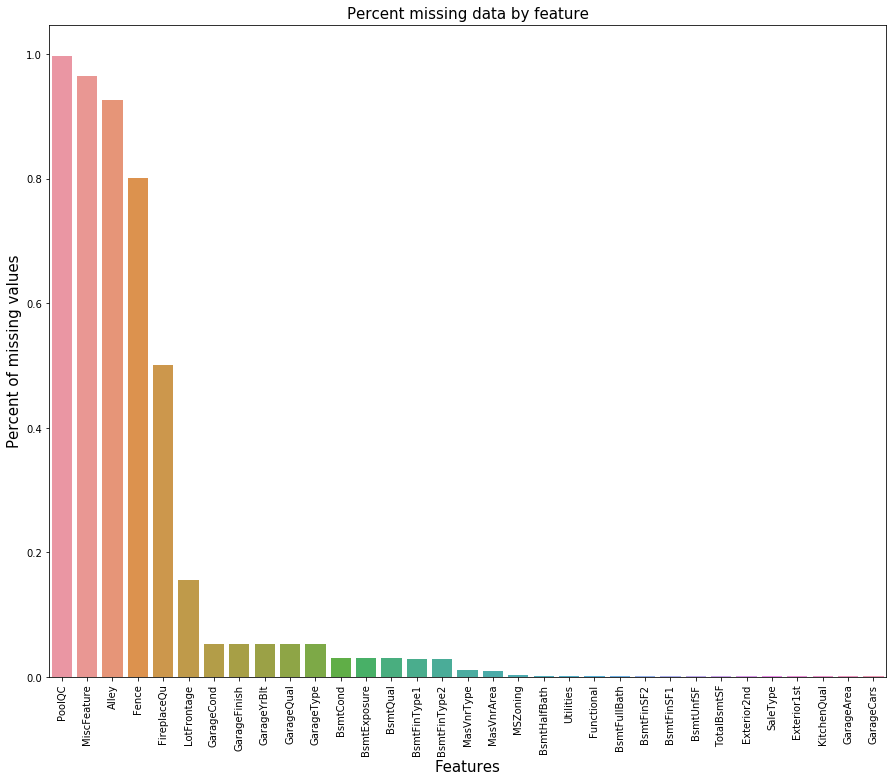

Total   Percent
PoolQC         1456  0.997944
MiscFeature    1408  0.965045
Alley          1352  0.926662
Fence          1169  0.801234
FireplaceQu     730  0.500343
LotFrontage     227  0.155586
GarageCond       78  0.053461
GarageFinish     78  0.053461
GarageYrBlt      78  0.053461
GarageQual       78  0.053461
GarageType       76  0.052090
BsmtCond         45  0.030843
BsmtExposure     44  0.030158
BsmtQual         44  0.030158
BsmtFinType1     42  0.028787
BsmtFinType2     42  0.028787
MasVnrType       16  0.010966
MasVnrArea       15  0.010281
MSZoning          4  0.002742
BsmtHalfBath      2  0.001371
Utilities         2  0.001371
Functional        2  0.001371
BsmtFullBath      2  0.001371
BsmtFinSF2        1  0.000685
BsmtFinSF1        1  0.000685
BsmtUnfSF         1  0.000685
TotalBsmtSF       1  0.000685
Exterior2nd       1  0.000685
SaleType          1  0.000685
Exterior1st       1  0.000685
KitchenQual       1  0.000685
GarageArea        1  0.000685
GarageCars        1  0.000685

In [8]:
missing_data_summary = summary_of_missing_data(dsc_test, True)
missing_data_summary

Як бачите у нас є 19 ознак в тренувальному наборі даних та 33 ознаки в тестовому наборі, в яких є пропущені дані.

Оскільки кожна така ознака має різний вплив на прогностичні можливості моделі і дані можуть бути відсутні з різних причин, то ж і очищення/заміну таких даних слід робити враховуючи індивідуальні особливості кожної ознаки. 

Спершу дослідимо на скільки ознаки пливают на вартість будинку та як вони корелюють між собою.

### Кореляція характеристик

Збудуємо матрицю кореляцій між характеризуючими ознаками та цільовою ознакою 'SalePrice'

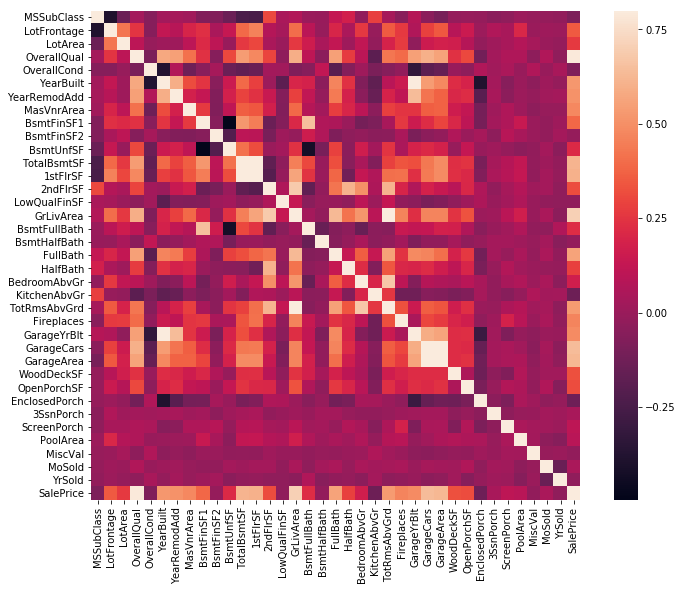

In [9]:
corrmat = dsc_train.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True)
plt.show()

Трохи "наблизимо" ті ознаки, які найбільше корелюють з цільомою ознакою.

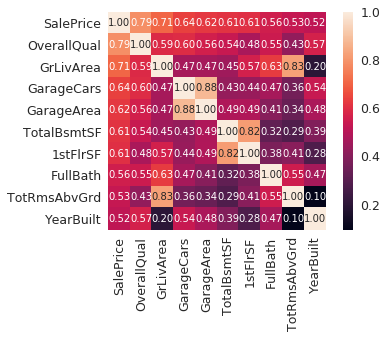

In [10]:
k = 10 # number of variables for heatmap
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(dsc_train[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

### Вказати/очистити відсутні значення

#### 1. Видалемо ознаки, які сильно пов'язані між собою через і мають схожий вплив на прогностичні здібності моделі

Як видно з матриці кореляції "GarageCars" і "GarageArea" достатньо сильно корелюють між собою, що можна пояснити тим, що чим більша площа гаража ("GarageArea") - тим більше автомобілей може вмістити цей гараж ("GarageCars"). Як ми бачимо "GarageCars" трохи більше корелює з "SalePrice" - залишимо його, і позбудемось "GarageArea". Зробимо те саме і для інших подібник дублюючих ознак в тренувальному та тестовому наборі даних, наприклад "TotalBsmtSF" та "1stFloor".

In [11]:
dsc_train = drop_features(dsc_train, ["GarageArea", "1stFlrSF", "GarageYrBlt", "TotRmsAbvGrd"])
dsc_test = drop_features(dsc_test, ["GarageArea", "1stFlrSF", "GarageYrBlt", "TotRmsAbvGrd"])

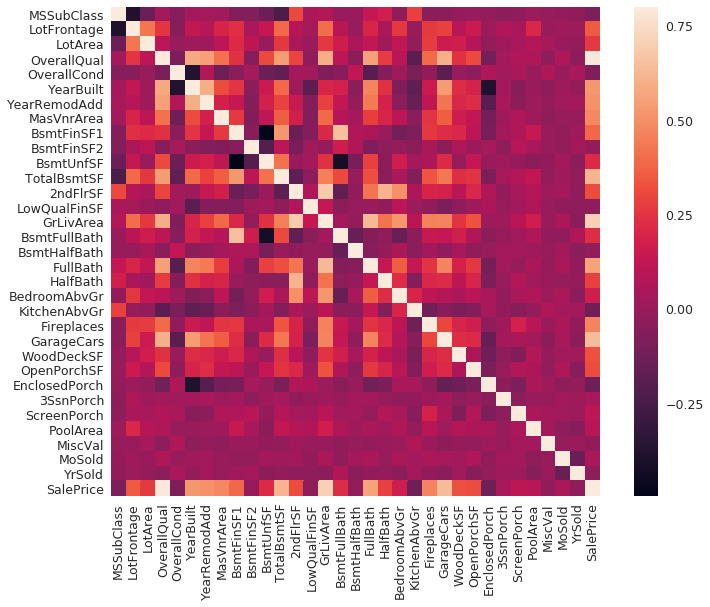

In [12]:
corrmat = dsc_train.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True)
plt.show()

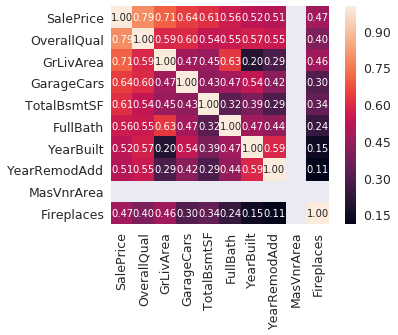

In [13]:
k = 10 # number of variables for heatmap
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(dsc_train[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

Ми позбулися деяких дублюючих ознак, але ми все ще маємо пропущені дані. Які з даних ми ще можемо видалити?

* "MiscFeature" - невідомо які ознаки, не охоплені іншими категоріями. Важко спрогнозувати як ця ознака впливає на прогнозтичні здібності моделі, оскільки в цю категорію може потрапити будь-яка ознака.
* "LotFrontage", "ExterQual" та "MasVnrArea" - оскільки ми не знаємо чому саме можуть бути відсутні данні в таких кількісних ознаках як "LotFrontage", "ExterQual" та "MasVnrArea" і чим можна їх заповнити, а також враховуючи низьку кореляцію цих ознак з "SalePrice" ми видалемо ці ознаки з датасету.

In [14]:
dsc_train = drop_features(dsc_train, ["MiscFeature", "LotFrontage", "ExterQual", "MasVnrArea"])
dsc_test = drop_features(dsc_test, ["MiscFeature", "LotFrontage", "ExterQual", "MasVnrArea"])

In [15]:
# missing_data_summary = summary_of_missing_data(dsc_train)
# missing_data_summary
missing_data_summary = summary_of_missing_data(dsc_test)
missing_data_summary

Total   Percent
PoolQC         1456  0.997944
Alley          1352  0.926662
Fence          1169  0.801234
FireplaceQu     730  0.500343
GarageQual       78  0.053461
GarageFinish     78  0.053461
GarageCond       78  0.053461
GarageType       76  0.052090
BsmtCond         45  0.030843
BsmtQual         44  0.030158
BsmtExposure     44  0.030158
BsmtFinType1     42  0.028787
BsmtFinType2     42  0.028787
MasVnrType       16  0.010966
MSZoning          4  0.002742
BsmtFullBath      2  0.001371
BsmtHalfBath      2  0.001371
Utilities         2  0.001371
Functional        2  0.001371
SaleType          1  0.000685
Exterior1st       1  0.000685
TotalBsmtSF       1  0.000685
Exterior2nd       1  0.000685
KitchenQual       1  0.000685
BsmtUnfSF         1  0.000685
GarageCars        1  0.000685
BsmtFinSF2        1  0.000685
BsmtFinSF1        1  0.000685

#### 2. Заповнимо пропущені ознаки

Оскільки ознаки в нашому датасеті є різного типу: кількісні та якісні, то ж і спосіб заповненя відсутніх даних в цих ознаках буде різний. Визначемо які з ознак кілкісні, а які якісні.

In [16]:
quality_features = list(dsc_train.select_dtypes(include=['object']).columns) # якісні ознаки
quantity_features = list(dsc_train.select_dtypes(include=['int64', 'float64']).columns) # кількісні ознаки

* "GarageCars" - скільки машин може вмістити в себе гараж. Це кількісна ознака. В залежності від того чому саме відсутнє це значення в тестовій виборці, його можна замінити на 0 (якщо гараж відсутній), або, наприклад, середнім значенням, якщо гараж є.
* "TotalBsmtSF" - загальна площа підвального приміщення. В залежності від того чому саме відсутнє це значення в тестовій виборці, його можна замінити на 0 (якщо площа підвального приміщення відсутня, бо відсутнє саме приміщення), або, наприклад, середнім значенням, якщо підвальне приміщення є, але не зазначене чере невідомі причини. 
* "BsmtFinSF1" - так само як і для "TotalBsmtSF".
* "BsmtHalfBath", "BsmtFullBath" - відсутні значення для цих ознак зустрічаються лише в 2 спостереженнях, я вирішив замітити їх на 0.0
* "Utilities", "MSZoning", "Functional", "Exterior1st", "Exterior2nd", "SaleType", "KitchenQual" - відсутні значення для цих якісних ознак зустрічаються лише в декількох спостереженнях, я вирішив замітити їх на фейкову категорію.

NA в таких якісних ознаках як "PoolQC", "Fence",  "Alley", "FireplaceQu", "GarageCond", "GarageType", "GarageFinish", "GarageQual", "BsmtFinType2", "BsmtExposure", "BsmtCond", "BsmtQual", "BsmtFinType1", "BsmtFinSF1", "MasVnrType" вказує на відсутність басейну, гаражу, підвалу абощо. Це може вплинути на вартість будинку. Як і якість подібних споруд, оскільки має значення чи потребують вони ремонту, чи вони перебувають у гарному стані. Для таких ознак створимо допоміжну ознаку, яка б визначала чи є в будинку басейну, гараж, підвал тощо (і тоді значення ознаки буде 1) чи ні (і тоді значення - 0).


І останнє, ми маємо одну відсутнє значення в "Electrical". Оскільки це лише одне спостереження, ми видалимо це спостереження і збережемо ознаку.

In [17]:
dsc_test[dsc_test['TotalBsmtSF'].isnull()] = 0.0
dsc_test[dsc_test['BsmtFinSF1'].isnull()] = 0.0
dsc_test[dsc_test['GarageCars'].isnull()] = 0.0
dsc_test[dsc_test['BsmtHalfBath'].isnull()] = 0.0
dsc_test[dsc_test['BsmtFullBath'].isnull()] = 0.0

dsc_test = encode_labels(dsc_test, ["Utilities", "MSZoning", "Functional", "Exterior1st", "Exterior2nd", "SaleType", "KitchenQual"])

quality_features = ["PoolQC", "Fence", "Alley", "FireplaceQu", "GarageCond", "GarageType", "GarageFinish", "GarageQual", "BsmtFinType2", "BsmtFinSF1", "BsmtExposure", "BsmtCond", "BsmtQual", "BsmtFinType1", "MasVnrType"]
is_exist_column = ["PoolQC", "Fence", "Alley", "FireplaceQu", "GarageCond", "BsmtCond", "MasVnrType"]

columns = quality_features
dsc_train = add_new_feature_is_exist_or_not(dsc_train, is_exist_column)
dsc_train = encode_labels(dsc_train, columns)
dsc_test = add_new_feature_is_exist_or_not(dsc_test, is_exist_column)
dsc_test = encode_labels(dsc_test, columns)

dsc_train = dsc_train.drop(dsc_train.loc[dsc_train['Electrical'].isnull()].index)

In [18]:
# missing_data_summary = summary_of_missing_data(dsc_train)
# missing_data_summary
missing_data_summary = summary_of_missing_data(dsc_test)
missing_data_summary

Empty DataFrame
Columns: [Total, Percent]
Index: []

In [19]:
quality_features = list(dsc_train.select_dtypes(include=['object']).columns) # якісні ознаки
quantity_features = list(dsc_train.select_dtypes(include=['int64', 'float64']).columns) # кількісні ознаки
dsc_train = encode_labels(dsc_train, quality_features)
dsc_test = encode_labels(dsc_test, quality_features)
quality_features = list(dsc_test.select_dtypes(include=['object']).columns) # якісні ознаки
quantity_features = list(dsc_test.select_dtypes(include=['int64', 'float64']).columns) # кількісні ознаки

###  Підготовка даних до тернування та прогнозу

In [20]:
# Видалемо колонку 'SalePrice' з тренувального набору даних, натомість створимо список 'SalePrice' для тренування 
y_train = dsc_train.xs('SalePrice', axis=1)
dsc_train = drop_features(dsc_train, ["SalePrice"])
print(f"Розмірність набору даних з мітками (вартість будинку) для тренування: {y_train.shape}")

Розмірність набору даних з мітками (вартість будинку) для тренування: (1459,)


### Тренування моделі

In [27]:
ETR = ExtraTreesRegressor(n_estimators=100, max_depth=4)
ETR.fit(dsc_train[:1000], y_train[:1000])
# ETR.fit(X, y)
print(f"Accuracy --> {ETR.score(dsc_train[1000:], y_train[1000:])*100}%")

Accuracy --> 77.42620275516462%


In [22]:
RFR = RandomForestRegressor(random_state=1, n_estimators=10, max_depth = 4)
RFR.fit(dsc_train[:1000], y_train[:1000])
# RFR.fit(X, y)
print(f"Accuracy --> {RFR.score(dsc_train[1000:], y_train[1000:])*100}%")

Accuracy --> 77.31121291649366%


In [23]:
GBR = GradientBoostingRegressor(n_estimators=100, max_depth=4)
GBR.fit(dsc_train[:1000], y_train[:1000])
# GBR.fit(X, y)
print(f"Accuracy --> {GBR.score(dsc_train[1000:], y_train[1000:])*100}%")

Accuracy --> 86.10736814286616%


### Прогноз вартості будинку на тестовому наборі даних

In [24]:
GBR = GradientBoostingRegressor(n_estimators=100, max_depth=4)
GBR.fit(dsc_train, y_train)
y_predicted = GBR.predict(dsc_test)

In [25]:
save_submission(test_ids, y_predicted)

'submissions/submission-20190611-154533.csv'